# Practical Statistics for Data Scientists (R)
# Chapter 5. Classification
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required R packages.

In [1]:
library(klaR)
library(MASS)
library(dplyr)
library(ggplot2)
library(FNN)
library(mgcv)
library(rpart)

Loading required package: MASS




Attaching package: ‘dplyr’




The following object is masked from ‘package:MASS’:

    select




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: nlme




Attaching package: ‘nlme’




The following object is masked from ‘package:dplyr’:

    collapse




This is mgcv 1.8-34. For overview type 'help("mgcv-package")'.



Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
PSDS_PATH <- file.path(dirname(dirname(getwd())))

loan3000 <- read.csv(file.path(PSDS_PATH, 'data', 'loan3000.csv'), stringsAsFactors=TRUE)
loan_data <- read.csv(file.path(PSDS_PATH, 'data', 'loan_data.csv.gz'), stringsAsFactors=TRUE)
full_train_set <- read.csv(file.path(PSDS_PATH, 'data', 'full_train_set.csv.gz'), stringsAsFactors=TRUE)

# order the outcome variable
loan3000$outcome <- ordered(loan3000$outcome, levels=c('paid off', 'default'))
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))
full_train_set$outcome <- ordered(full_train_set$outcome, levels=c('paid off', 'default'))

# Naive Bayes
## The Naive Solution

In [3]:
naive_model <- NaiveBayes(outcome ~ purpose_ + home_ + emp_len_, 
                          data = na.omit(loan_data))
naive_model$table

new_loan <- loan_data[147, c('purpose_', 'home_', 'emp_len_')]
row.names(new_loan) <- NULL
new_loan

predict(naive_model, new_loan)

$purpose_
          var
grouping   credit_card debt_consolidation home_improvement major_purchase
  paid off  0.18759649         0.55215915       0.07150104     0.05359270
  default   0.15151515         0.57571347       0.05981209     0.03727229
          var
grouping      medical      other small_business
  paid off 0.01424728 0.09990737     0.02099599
  default  0.01433549 0.11561025     0.04574126

$home_
          var
grouping    MORTGAGE       OWN      RENT
  paid off 0.4894800 0.0808963 0.4296237
  default  0.4313440 0.0832782 0.4853778

$emp_len_
          var
grouping     < 1 Year   > 1 Year
  paid off 0.03105289 0.96894711
  default  0.04728508 0.95271492


purpose_,home_,emp_len_
<fct>,<fct>,<fct>
small_business,MORTGAGE,> 1 Year


paid off,default
0.3463013,0.6536987


In [4]:
print(predict(naive_model, new_loan))

$class
[1] default
Levels: paid off default

$posterior
      paid off   default
[1,] 0.3463013 0.6536987



Due to changes in R's default behavior of converting strings to factors, it is important to convert string columns to factors when using the naive Bayes implementation in `klaR`. Use either `stringsAsFactors=TRUE` when loading the data or convert to factors explicitly. 

### Example not in book

paid off,0.5347933,0.1238649
default,0.4632195,0.1233597
paid off,7.294367,4.018183
default,8.770084,4.373793


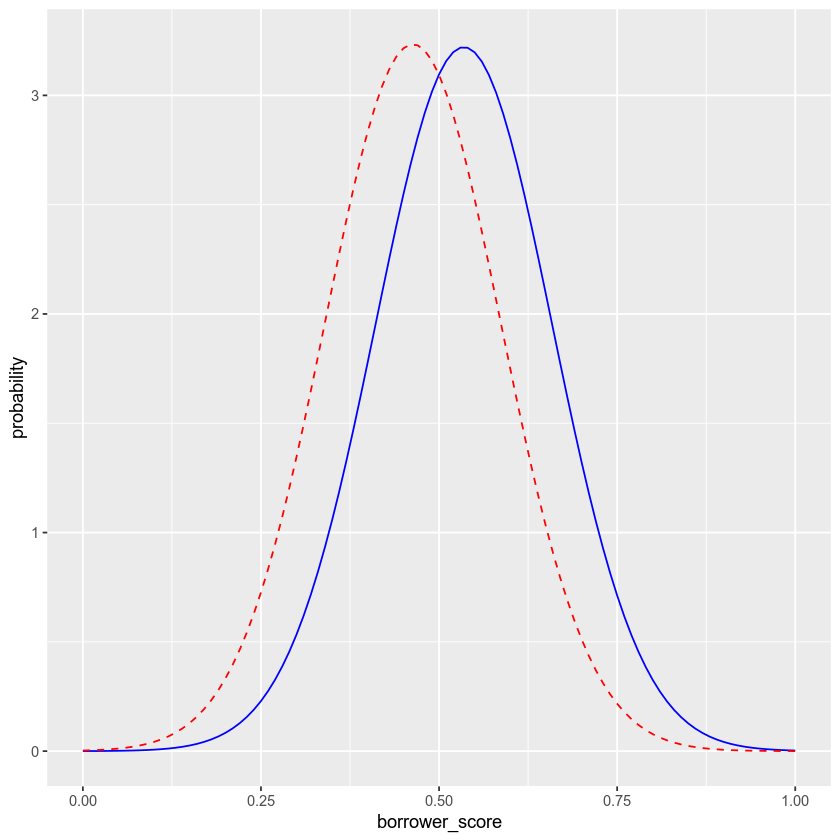

In [5]:
less_naive <- NaiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                           purpose_ + home_ + emp_len_, data = loan_data)
less_naive$table[1:2]

stats <- less_naive$table[[1]]
graph <- ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
  stat_function(fun = dnorm, color='blue', linetype=1, 
                args=list(mean=stats[1, 1], sd=stats[1, 2])) +
  stat_function(fun = dnorm, color='red', linetype=2, 
                args=list(mean=stats[2, 1], sd=stats[2, 2])) +
  labs(y='probability')
graph

# Discriminant Analysis
## A Simple Example

In [6]:
loan_lda <- lda(outcome ~ borrower_score + payment_inc_ratio,
                data=loan3000)
loan_lda$scaling

,LD1
borrower_score,-7.17583880
payment_inc_ratio,0.09967559


In [7]:
pred <- predict(loan_lda)
print(head(pred$posterior))

   paid off   default
1 0.4464563 0.5535437
2 0.4410466 0.5589534
3 0.7273038 0.2726962
4 0.4937462 0.5062538
5 0.3900475 0.6099525
6 0.5892594 0.4107406


### Figure 5.1

In [8]:
# pred <- predict(loan_lda)
# lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

# x <- seq(from=.33, to=.73, length=100)
# y <- seq(from=0, to=20, length=100)
# newdata <- data.frame(borrower_score=x, payment_inc_ratio=y)
# pred <- predict(loan_lda, newdata=newdata)
# lda_df0 <- cbind(newdata, outcome=pred$class)

# graph <- ggplot(data=lda_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) +
#   geom_point(alpha=.6) +
#   scale_color_gradient2(low='white', high='blue') +
#   scale_x_continuous(expand=c(0,0)) + 
#   scale_y_continuous(expand=c(0,0), lim=c(0, 20)) + 
#   geom_line(data=lda_df0, col='darkgreen', size=2, alpha=.8) +
#   theme_bw()
# graph

In [9]:
# # [Book]
# graph
# dev.off()

Warning message:
“Removed 18 rows containing missing values (geom_point).”


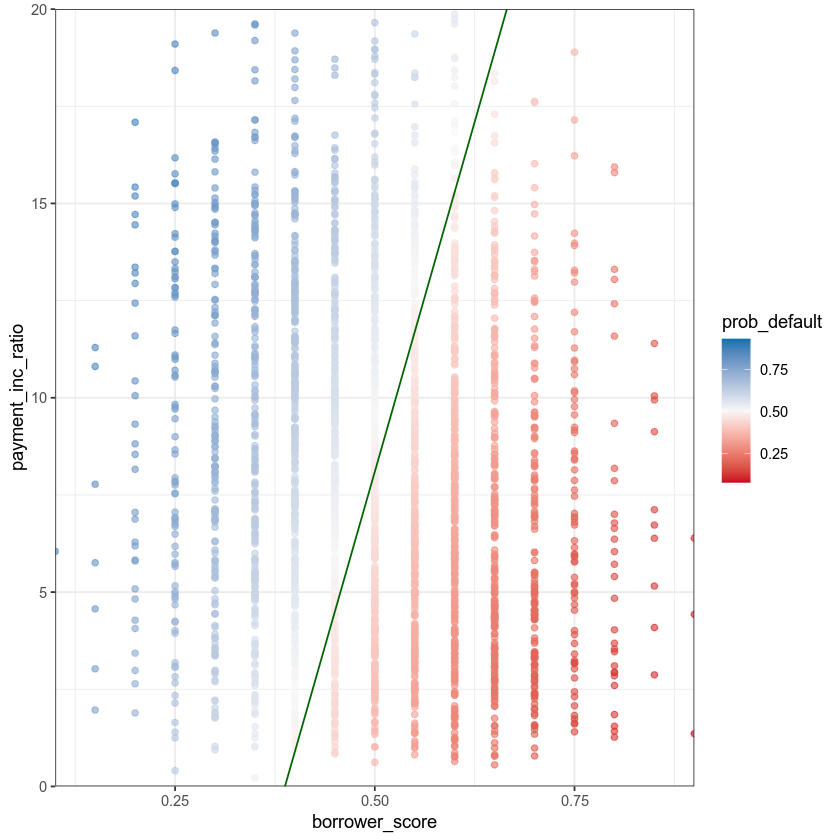

In [10]:
pred <- predict(loan_lda)
lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

center <- 0.5 * (loan_lda$mean[1, ] + loan_lda$mean[2, ])
slope <- -loan_lda$scaling[1] / loan_lda$scaling[2]
intercept = center[2] - center[1] * slope

graph <- ggplot(data=lda_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) +
  geom_point(alpha=.6) +
  scale_color_gradientn(colors=c('#ca0020', '#f7f7f7', '#0571b0')) +
  scale_x_continuous(expand=c(0,0)) + 
  scale_y_continuous(expand=c(0,0), lim=c(0, 20)) + 
  geom_abline(slope=slope, intercept=intercept, color='darkgreen') +
  theme_bw()

graph

# Logistic regression
## Logistic Response Function and Logit


Call:  glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Coefficients:
               (Intercept)           payment_inc_ratio  
                   1.63809                     0.07974  
purpose_debt_consolidation    purpose_home_improvement  
                   0.24937                     0.40774  
    purpose_major_purchase             purpose_medical  
                   0.22963                     0.51048  
             purpose_other      purpose_small_business  
                   0.62066                     1.21526  
                  home_OWN                   home_RENT  
                   0.04833                     0.15732  
         emp_len_ > 1 Year              borrower_score  
                  -0.35673                    -4.61264  

Degrees of Freedom: 45341 Total (i.e. Null);  45330 Residual
Null Deviance:	    62860 
Residual Deviance: 57510 	AIC: 57540


Call:
glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.51951  -1.06908  -0.05853   1.07421   2.15528  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 1.638092   0.073708  22.224  < 2e-16 ***
payment_inc_ratio           0.079737   0.002487  32.058  < 2e-16 ***
purpose_debt_consolidation  0.249373   0.027615   9.030  < 2e-16 ***
purpose_home_improvement    0.407743   0.046615   8.747  < 2e-16 ***
purpose_major_purchase      0.229628   0.053683   4.277 1.89e-05 ***
purpose_medical             0.510479   0.086780   5.882 4.04e-09 ***
purpose_other               0.620663   0.039436  15.738  < 2e-16 ***
purpose_small_business      1.215261   0.063320  19.192  < 2e-16 ***
home_OWN                    0.048330   0.038036   1.271    0.204    
home_RENT                   0.

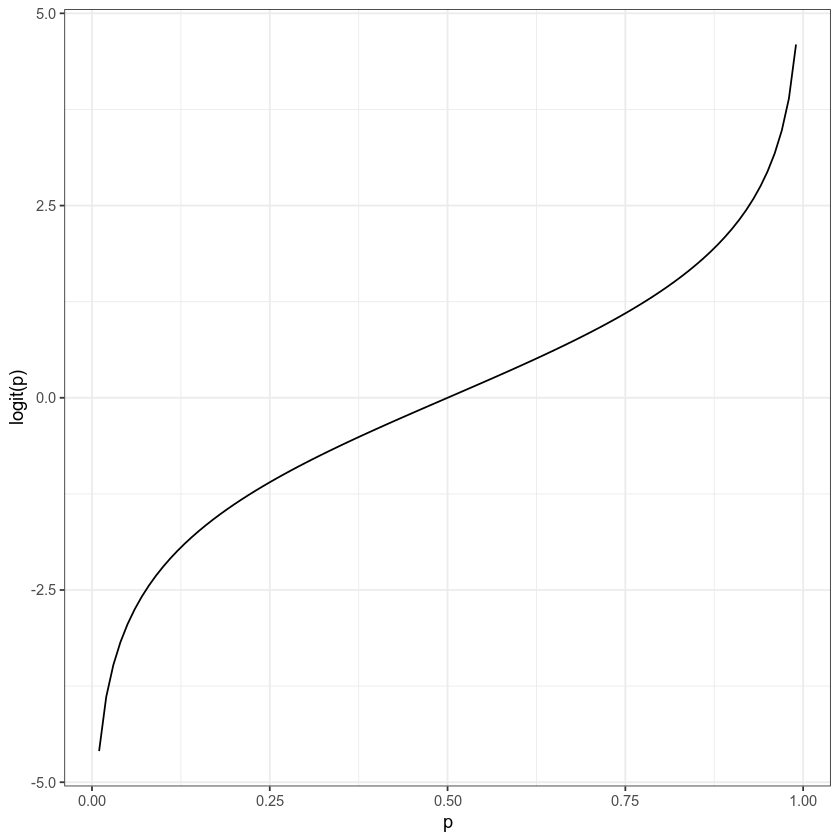

In [11]:
logistic_model <- glm(outcome ~ payment_inc_ratio + purpose_ + 
                        home_ + emp_len_ + borrower_score,
                      data=loan_data, family='binomial')
logistic_model
summary(logistic_model)

p <- seq(from=0.01, to=.99, by=.01)
df <- data.frame(p = p,
                 logit = log(p/(1-p)),
                 odds = p/(1-p))

graph <- ggplot(data=df, aes(x=p, y=logit)) +
  geom_line() +
  labs(x = 'p', y='logit(p)') +
  theme_bw()
graph

## Predicted Values from Logistic Regression

In [12]:
pred <- predict(logistic_model)
summary(pred)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.704774 -0.518825 -0.008539  0.002564  0.505061  3.509606 

In [13]:
prob <- 1/(1 + exp(-pred))
summary(prob)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06269 0.37313 0.49787 0.50000 0.62365 0.97096 

## Interpreting the Coefficients and Odds Ratios

Warning message:
“Removed 49 row(s) containing missing values (geom_path).”


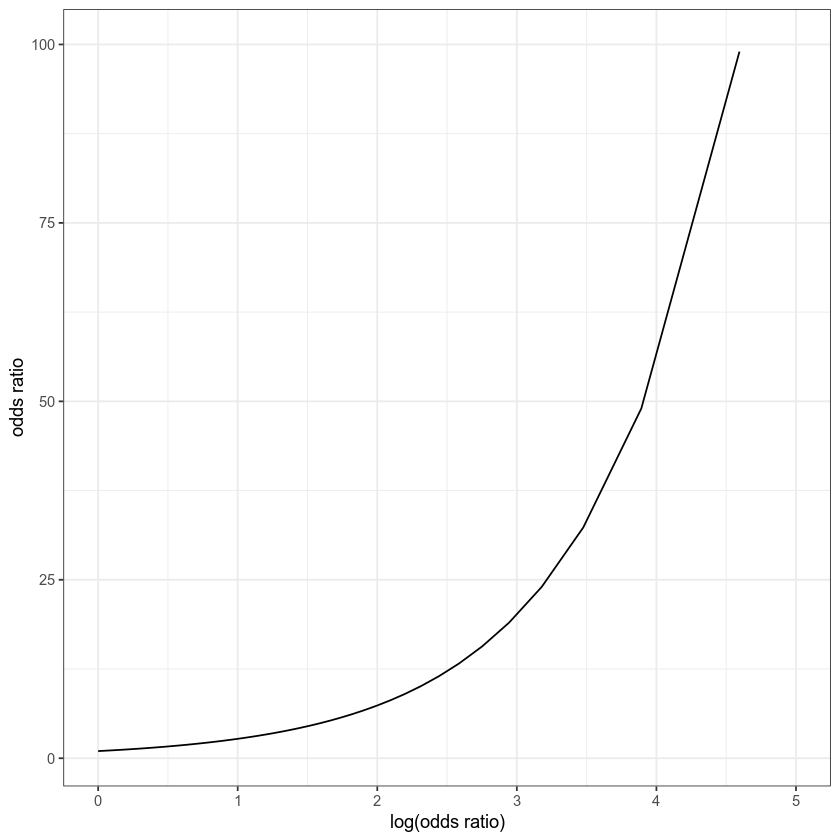

In [14]:
graph <- ggplot(data=df, aes(x=logit, y=odds)) +
  geom_line() +
  labs(x='log(odds ratio)', y='odds ratio') +
  ylim(1, 100) +
  xlim(0, 5) +
  theme_bw()
graph

## Logistic regression with splines

In [15]:
logistic_gam <- gam(outcome ~ s(payment_inc_ratio) + purpose_ + 
                      home_ + emp_len_ + s(borrower_score),
                    data=loan_data, family='binomial')
logistic_gam


Family: binomial 
Link function: logit 

Formula:
outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + 
    s(borrower_score)

Estimated degrees of freedom:
7.66 4.17  total = 21.83 

UBRE score: 0.2681506     

## Assessing the Model¶

Warning message:
“Removed 9 rows containing missing values (geom_point).”


Warning message:
“Removed 9 row(s) containing missing values (geom_path).”


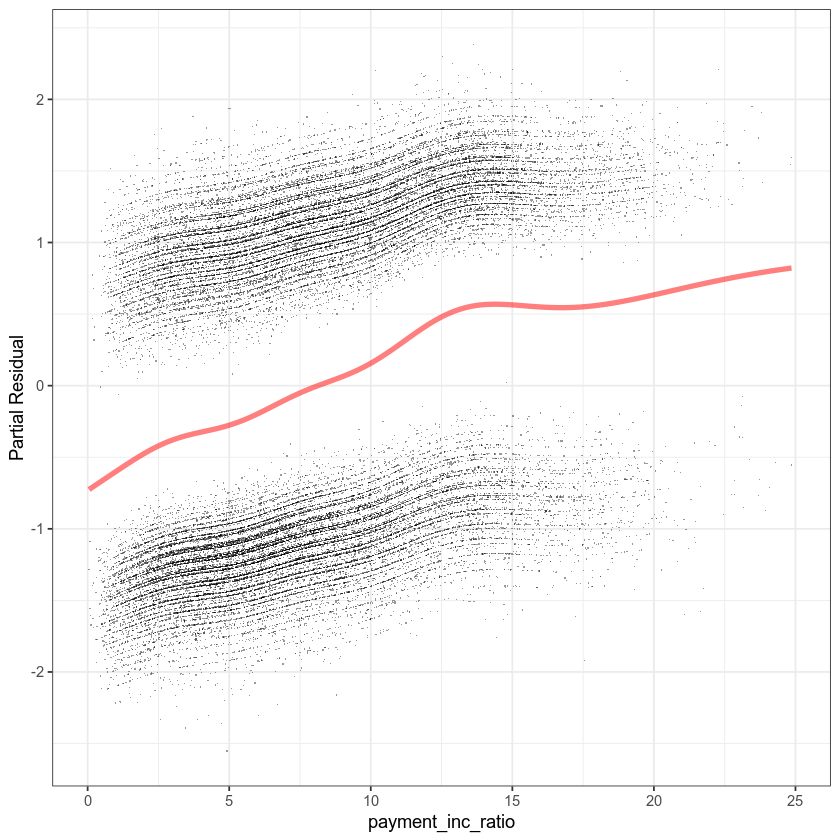

In [16]:
terms <- predict(logistic_gam, type='terms')
partial_resid <- resid(logistic_gam) + terms
df <- data.frame(payment_inc_ratio = loan_data[, 'payment_inc_ratio'],
                 terms = terms[, 's(payment_inc_ratio)'],
                 partial_resid = partial_resid[, 's(payment_inc_ratio)'])

graph <- ggplot(df, aes(x=payment_inc_ratio, y=partial_resid, solid = FALSE)) +
  geom_point(shape=46, alpha=0.4) +
  geom_line(aes(x=payment_inc_ratio, y=terms), 
            color='red', alpha=0.5, size=1.5) +
  labs(y='Partial Residual') +
  xlim(0, 25) +
  theme_bw()
graph

Warning message:
“Removed 9 rows containing missing values (geom_point).”


Warning message:
“Removed 9 row(s) containing missing values (geom_path).”


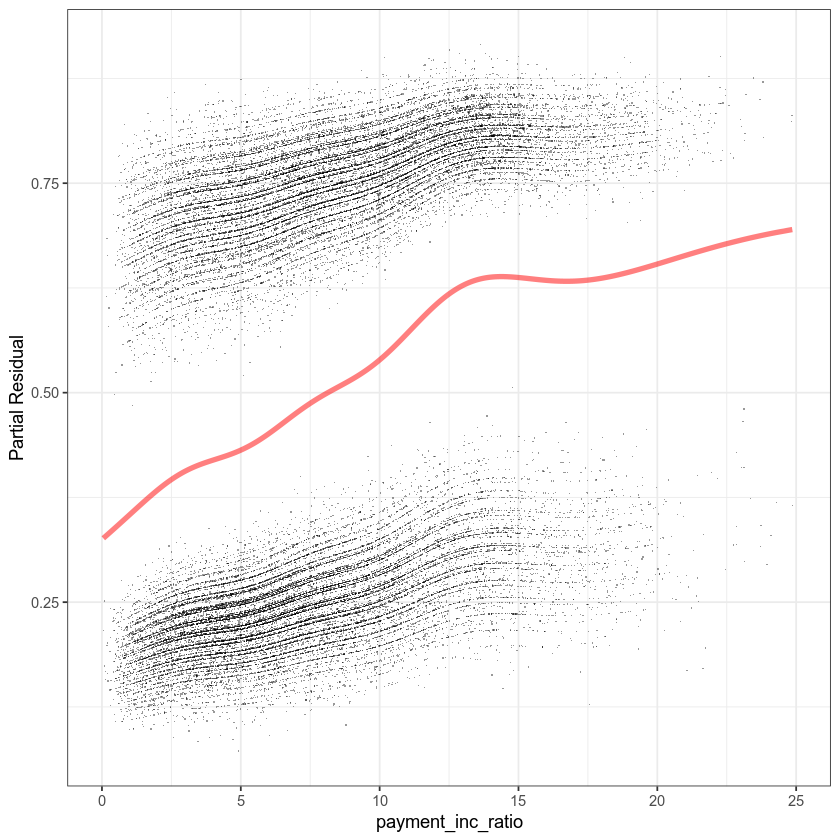

In [17]:
df <- data.frame(payment_inc_ratio = loan_data[, 'payment_inc_ratio'],
                 terms = 1/(1 + exp(-terms[, 's(payment_inc_ratio)'])),
                 partial_resid = 1/(1 + exp(-partial_resid[, 's(payment_inc_ratio)'])))

graph <- ggplot(df, aes(x=payment_inc_ratio, y=partial_resid, solid = FALSE)) +
  geom_point(shape=46, alpha=0.4) +
  geom_line(aes(x=payment_inc_ratio, y=terms), 
            color='red', alpha=0.5, size=1.5) +
  labs(y='Partial Residual') +
  xlim(0, 25) +
  theme_bw()
graph

# Evaluating Classification Models
## Confusion Matrix

In [18]:
# Confusion matrix
pred <- predict(logistic_gam, newdata=loan_data)
pred_y <- as.numeric(pred > 0)
true_y <- as.numeric(loan_data$outcome=='default')
true_pos <- (true_y==1) & (pred_y==1)
true_neg <- (true_y==0) & (pred_y==0)
false_pos <- (true_y==0) & (pred_y==1)
false_neg <- (true_y==1) & (pred_y==0)
conf_mat <- matrix(c(sum(true_pos), sum(false_pos),
                     sum(false_neg), sum(true_neg)), 2, 2)
colnames(conf_mat) <- c('Yhat = 1', 'Yhat = 0')
rownames(conf_mat) <- c('Y = 1', 'Y = 0')
conf_mat

,Yhat = 1,Yhat = 0
Y = 1,14293,8378
Y = 0,8051,14620


## Precision, Recall, and Specificity

In [19]:
# precision
conf_mat[1, 1] / sum(conf_mat[,1])
# recall
conf_mat[1, 1] / sum(conf_mat[1,])
# specificity
conf_mat[2, 2] / sum(conf_mat[2,])

[1] 0.6396796

[1] 0.630453

[1] 0.6448767

## ROC Curve

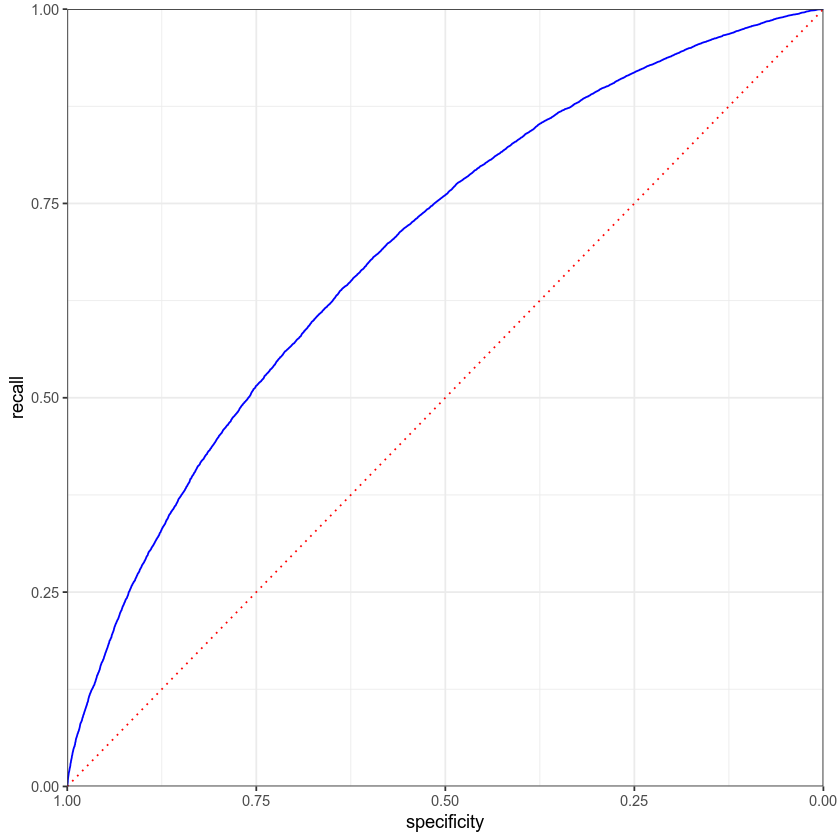

In [20]:
idx <- order(-pred)
recall <- cumsum(true_y[idx] == 1) / sum(true_y == 1)
specificity <- (sum(true_y == 0) - cumsum(true_y[idx] == 0)) / sum(true_y == 0)
roc_df <- data.frame(recall = recall, specificity = specificity)

graph <- ggplot(roc_df, aes(x=specificity, y=recall)) +
  geom_line(color='blue') + 
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) + 
  geom_line(data=data.frame(x=(0:100) / 100), aes(x=x, y=1-x),
            linetype='dotted', color='red') +
  theme_bw() + theme(plot.margin=unit(c(5.5, 10, 5.5, 5.5), "points"))
graph

## AUC

In [21]:
sum(roc_df$recall[-1] * diff(1-roc_df$specificity))
head(roc_df)

[1] 0.6926232

,recall,specificity
,<dbl>,<dbl>
1,4.410921e-05,1.0000000
2,8.821843e-05,1.0000000
3,8.821843e-05,0.9999559
4,1.323276e-04,0.9999559
5,1.764369e-04,0.9999559
6,2.205461e-04,0.9999559


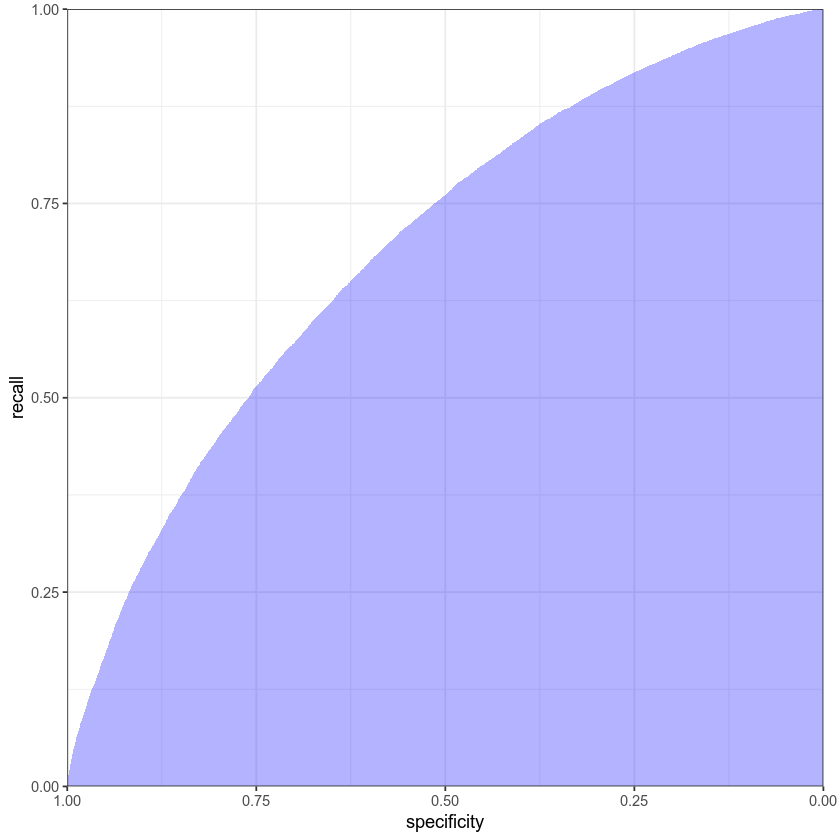

In [22]:
graph <- ggplot(roc_df, aes(specificity)) +
  geom_ribbon(aes(ymin=0, ymax=recall), fill='blue', alpha=.3) +
  scale_x_reverse(expand=c(0, 0)) +
  scale_y_continuous(expand=c(0, 0)) +
  labs(y='recall') +
  theme_bw() + theme(plot.margin=unit(c(5.5, 10, 5.5, 5.5), "points"))
graph

# Strategies for Imbalanced Data
## Undersampling

In [23]:
mean(full_train_set$outcome=='default')

full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ + 
                            emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, family='binomial')
pred <- predict(full_model)
mean(pred > 0)

 mean(full_train_set$outcome=='default') / mean(pred > 0)

[1] 0.1889455

[1] 0.003942094

[1] 47.93023

## Oversampling and Up/Down Weighting

In [24]:
wt <- ifelse(full_train_set$outcome=='default', 
             1 / mean(full_train_set$outcome == 'default'), 1)
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + 
                  home_ + emp_len_+ dti + revol_bal + revol_util,
                  data=full_train_set, weight=wt, family='quasibinomial')
pred <- predict(full_model)
mean(pred > 0)

[1] 0.5767208

## Data Generation
There are a variety of SMOTE implementation available in R. The package `unbalanced` provides SMOTE and other methods. Unfortunately, it's not working for your dataset. 

The SMOTE implementation in the package `DMwR` works

In [25]:
loan_data_samp <- sample_frac(full_train_set, .05)

# # install.packages('unbalanced')
# library(unbalanced)
# head(full_train_set)
# smote_data <- ubSMOTE(loan_data_samp, loan_data_samp$outcome, 
#                       perc.over = 2000, k = 5, perc.under = 100)
# head(smote_data)

# install.packages('DMwR')
library(DMwR)
smote_data <- SMOTE(outcome ~ ., loan_data_samp, 
                    perc.over = 2000, perc.under=100)
dim(loan_data_samp)
dim(smote_data)
head(smote_data)

Loading required package: lattice



Loading required package: grid



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



[1] 5999   19

[1] 47273    19

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<fct>,<fct>,<fct>
2548,Fully Paid,5000,60 months,13800,5.91,8.79130,1717,9.5,other,RENT,0,1,6,7.0,paid off,0,other,RENT,< 1 Year
1023,Fully Paid,7000,36 months,90000,9.56,2.97893,13896,49.4,house,RENT,1,1,15,5.4,paid off,2,home_improvement,RENT,> 1 Year
2613,Fully Paid,3900,36 months,45000,14.61,3.36373,29896,84.5,debt_consolidation,MORTGAGE,1,1,5,5.2,paid off,6,debt_consolidation,MORTGAGE,> 1 Year
4981,Fully Paid,35000,60 months,87000,20.18,13.72040,37697,96.2,credit_card,RENT,1,1,12,3.0,paid off,11,credit_card,RENT,> 1 Year
2590,Fully Paid,3250,36 months,8000,6.30,17.29200,0,0.0,small_business,OWN,1,1,5,2.8,paid off,2,small_business,OWN,> 1 Year
866,Fully Paid,5500,36 months,55000,10.39,3.96000,1686,17.9,small_business,RENT,0,1,12,5.6,paid off,5,small_business,RENT,> 1 Year


## Exploring the Predictions

In [26]:
loan_tree <- rpart(outcome ~ borrower_score + payment_inc_ratio,
                   data=loan3000, 
                   control = rpart.control(cp=.005))

geom_abline(slope=slope, intercept=intercept, color='darkgreen')
lda_pred <- data.frame(borrower_score = c((0 - intercept) / slope, (20 - intercept) / slope),
                       payment_inc_ratio = c(0, 20),
                       method = rep('LDA', 2))

tree_pred <- data.frame(borrower_score = c(0.375, 0.375, 0.475, 0.475, 0.575, 0.575),
                        payment_inc_ratio = c(0, 4.426,  4.426, 10.42, 10.42, 20),
                        method = rep('Tree', 6))

glm0 <- glm(outcome ~ (payment_inc_ratio) +  (borrower_score),
            data=loan3000, family='binomial')
y <- seq(from=0, to=20, length=100)
x <- (-glm0$coefficients[1] - glm0$coefficients[2]*y)/glm0$coefficients[3]
glm0_pred <- data.frame(borrower_score=x, payment_inc_ratio=y, method='Logistic')

gam1 <- gam(outcome ~ s(payment_inc_ratio) +  s(borrower_score),
            data=loan3000, family='binomial')
gam_fun <- function(x){
  rss <- sum(predict(gam1, newdata=data.frame(borrower_score=x, payment_inc_ratio=y))^2)
}
est_x <- nlminb(seq(from=.33, to=.73, length=100), gam_fun )
gam1_pred <- data.frame(borrower_score=est_x$par, payment_inc_ratio=y, method="GAM")

loan_fits <- rbind(lda_pred,
                   tree_pred,
                   glm0_pred,
                   gam1_pred)

mapping: intercept = ~intercept, slope = ~slope 
geom_abline: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

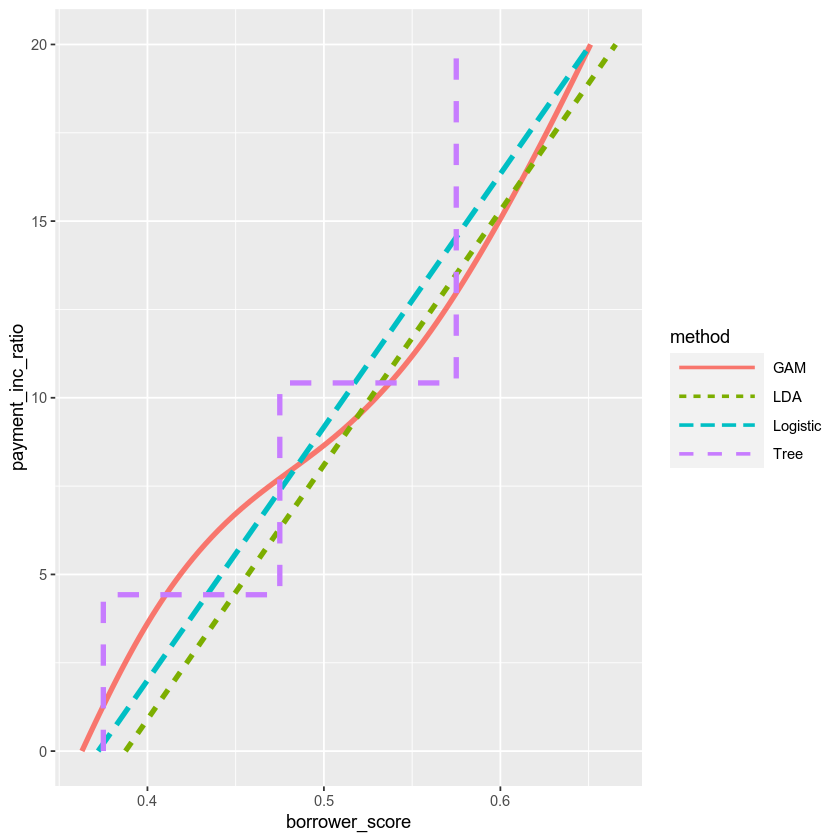

In [27]:
graph <- ggplot(data=loan_fits, aes(x=borrower_score, y=payment_inc_ratio, color=method, linetype=method)) +
  geom_line(size=1.5) +
  theme(legend.key.width = unit(2,"cm")) +
  guides(linetype = guide_legend(override.aes = list(size = 1)))
graph